<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Convolutional Neural Network for Shape Classification</h1> 

<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify shapes. We will reshape the images to make them faster to process. The shapes are represented by numbered classes: Square = 0, Triangle = 1, Star = 2, Circle = 3. </p>

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#Train">Define Softmax, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>40 min</strong> (15 min to train model)</p>

<hr>

<h2>Preparation</h2>

First we will download the zipped images and then unzip them. Note you may need to reload the files if you restart.

In [1]:
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/circle.zip
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/square.zip
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/star.zip 
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/triangle.zip 

--2023-10-19 17:26:05--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/circle.zip
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5972318 (5.7M) [application/zip]
Saving to: ‘circle.zip’

circle.zip          100%[===================>]   5.70M  2.54MB/s    in 2.2s    

2023-10-19 17:26:09 (2.54 MB/s) - ‘circle.zip’ saved [5972318/5972318]

--2023-10-19 17:26:09--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/square.zip
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.app

In [2]:
!unzip -q -o circle.zip
!unzip -q -o square.zip
!unzip -q -o star.zip
!unzip -q -o triangle.zip

In [3]:
# Import the libraries we need to use in this lab
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time

Define the function <code>plot_channels</code> to plot out the kernel parameters of  each channel:

In [4]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs . 

In [5]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function <code>plot_activation</code> to plot out the activations of the *Convolutional* layers:

In [6]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.

In [7]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))

In [8]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None, train=True):
        
        # Image directory
        current_working_directory=os.getcwd()

        folders_list=['square','triangle','star','circle']
        class_of_folder=[0,1,2,3] 
        path_of_folders=[os.path.join(current_working_directory,file)  for file in folders_list]
        path_of_folders
        count=0

        self.sqare_list=[
            (class_lable,os.path.join(path_of_folder,file_name)) for class_lable,path_of_folder in zip(
                class_of_folder,path_of_folders
            ) for file_name in os.listdir(path_of_folder) if file_name.endswith(".png")
        ]

        self.transform=transform
        
        if train:
            self.sqare_list=[self.sqare_list[i] for i in range(len(self.sqare_list)) if i%4!=0 ]
            self.len=len(self.sqare_list)
        else:
            self.sqare_list=self.sqare_list[::4]
            self.len=len(self.sqare_list)
        
        self.len=len(self.sqare_list)
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        y,image_path=self.sqare_list[idx]
        # Image file path
        
        # Open image file
        image = Image.open(image_path)
        
        # The class label for the image
        y = torch.tensor(y)
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="Makeup_Data">Get the Data</h2> 

<h1> Question 1</h1> Create a training dataset by creating a <code>Dataset</code> object called <code>train_dataset</code>, make sure the following parameters have been set:
<ul>
  <li> Resize the image using the  transform <code>Resize()</code> to 16x16</li>
  <li>Convert the image to a tensor using the transform  <code>ToTensor()</code></li>
  <li>Use Compose  method  <code>transforms.Compose</code> to compose the transforms </li>
    <li> Set the parameter <code>transform</code> to the transforms.Compose</li>
   <li>Set the parameter <code>train</code> to <code>True</code>  </li>
</ul>    
Find the class of the samples  100, 3000, 6000, 7000 and 10000 : 

In [9]:
# Write your code here:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
train_dataset=Dataset(transform=composed, train=True)

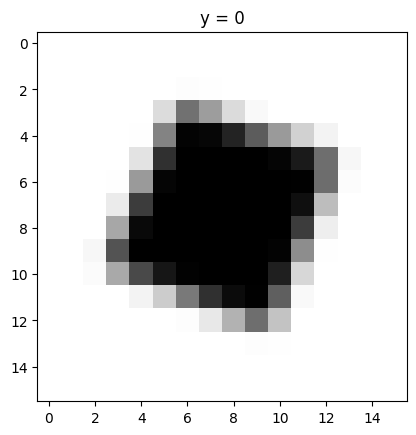

In [10]:
show_data(train_dataset[100])

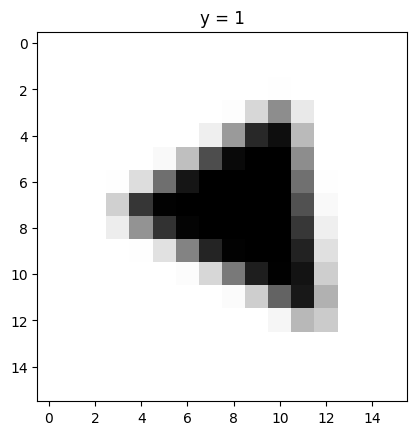

In [11]:
show_data(train_dataset[3000])

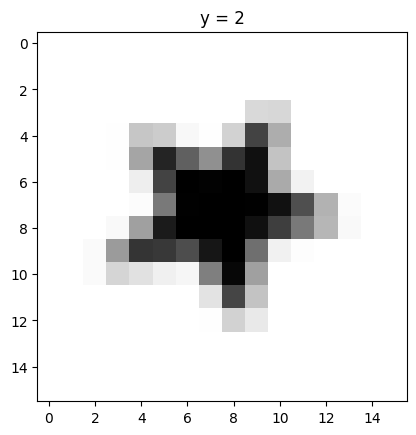

In [12]:
show_data(train_dataset[6000])

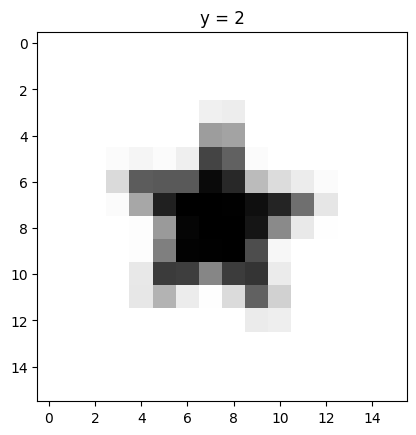

In [13]:
show_data(train_dataset[7000])

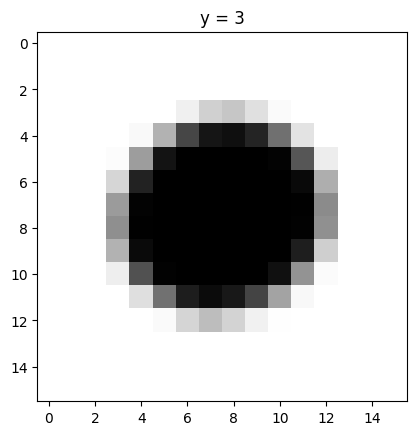

In [14]:
show_data(train_dataset[10000])

<h1> Question 2</h1> Create a validation/test dataset by creating a <code>Dataset</code> object called <code>test_dataset</code>, make sure the following parameters have been set:
<ul>
  <li> Resize the image using the  transform <code>Resize()</code> to 16x16</li>
  <li>Convert the image to a tensor using the transform  <code> ToTensor()</code></li>
  <li>Use Compose  method  <code>transforms.Compose</code> to compose the transforms </li>
    <li> Set the parameter <code>transform</code> to the transforms.Compose</li>
   <li>Set the parameter <code>train</code> to <code>False</code>  </li>
</ul>    
Find the class of the samples  10, 1500, and 2000: 

In [15]:
# Make the validating 
test_dataset=Dataset(transform=composed, train=False)

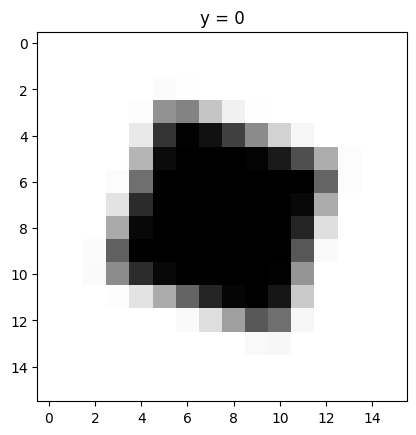

In [16]:
show_data(test_dataset[10])

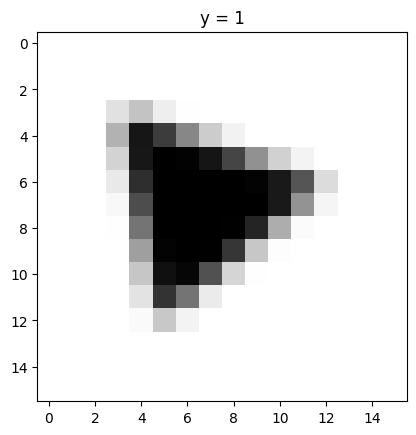

In [17]:
show_data(test_dataset[1500])

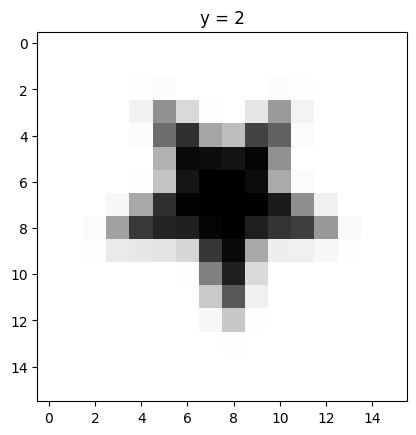

In [18]:
show_data(test_dataset[2000])

<h1 id="CNN">Build a Convolutional Neural Network Network Class</h1>

Build a Convolutional  Network class with with the following properties:
<ul>
    <li> first layer use <code>nn.Conv2d</code> with the following parameter values <code> in_channels=1, out_channels=16, kernel_size=5, padding=2</code>    </li>  <li>second layer use <code>nn.MaxPool2d</code> with the following parameter values<code>kernel_size=2</code>  </li> 
   <li> third layer use <code>nn.Conv2d</code> with the following parameter values <code> in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2</code>    </li>
   <li>fourth layer use <code>nn.MaxPool2d</code> with the following parameter values<code>kernel_size=2</code>  </li> 
    <li>finally add one dense layer using <code>nn.Linear</code> the input should be <code>32 * 4 * 4</code>, the output should be the number of classes </li>
</ul>  
The names for all these layers can be found in the forward function.

In [19]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        # add the cnn properties here
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 4)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

Create the object and call it <code>model</code>:

In [20]:
# Create the model object using CNN class
model=CNN()

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.

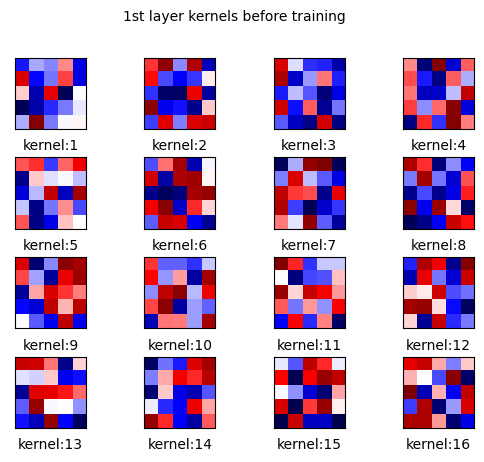

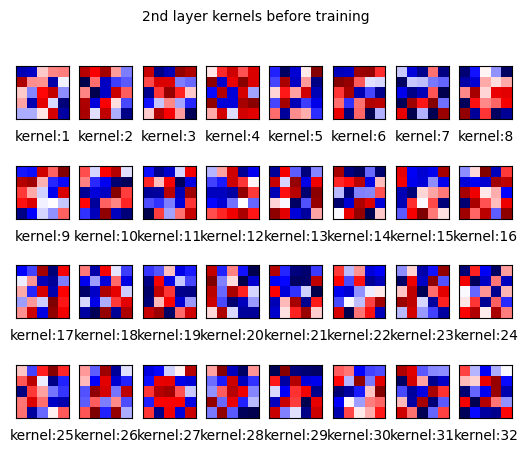

In [21]:
# Plot the parameters
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Test the model using the following line of code to see if you an output:

In [22]:
model(train_dataset[0][0].unsqueeze(0))

tensor([[-0.0813, -0.0079, -0.0922,  0.0497]], grad_fn=<AddmmBackward0>)

<h1> Question 3 </h1>  <h2 id="CNN">Setup the paramters for training</h2>

<ul>
    <li> create the following four objects that are used to train the model </li> 
   <li> in this section you will use the  <code>torch.optim.Adam </code> optimizer, input the model parameters, set the learning rate to <code>0.001</code>, and name the object <code>optimizer</code></li>
    <li> you will also use <code>nn.CrossEntropyLoss</code> as your criteron, create the object and name it <code>criterion</code> </li>
    <li>create a train loader object  <code>train_loader</code> using the dataset object <code>train_dataset</code>, using the function <code>torch.utils.data.DataLoader</code>, and set the batch size to <code>5000</code>  </li> 
   <li>create a validation loader object  <code>validation_loader</code> using the dataset object <code>test_dataset</code>, using the function <code>torch.utils.data.DataLoader</code>, and set the batch size to <code>5000</code>  </li> 
</ul>  
Create your objects here:

In [23]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset=train_dataset, batch_size=5000)
validation_loader = DataLoader(dataset=test_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy

**(This may take a long time)** / 14 min on my PC

In [24]:
%%time
# Train the model

n_epochs=120
cost_list=[]  
accuracy_list=[]
N_test=len(test_dataset)
start_time = time.time()
for epoch in range(n_epochs):
    COST=0
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        COST+=loss.data

    cost_list.append(COST)
    correct=0

    #perform a prediction on the validation  data
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)

CPU times: user 22min 54s, sys: 1min 43s, total: 24min 37s
Wall time: 14min 11s


<!--Empty Space for separating topics-->

<h1>Question 4 </h1>
<h2 id="Result">Analyze Results</h2> 

Plot the loss and accuracy on the validation data:

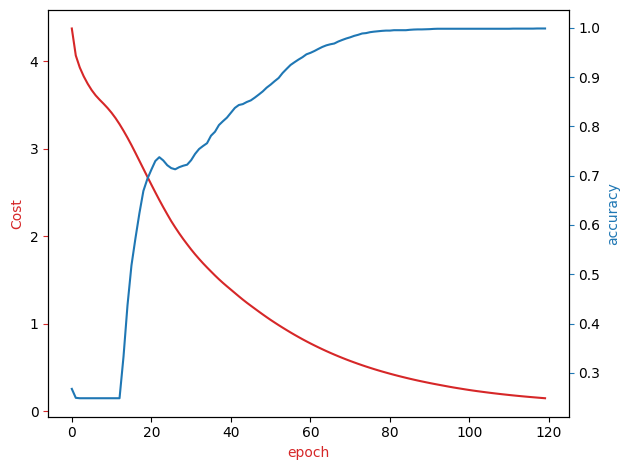

In [25]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers:

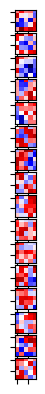

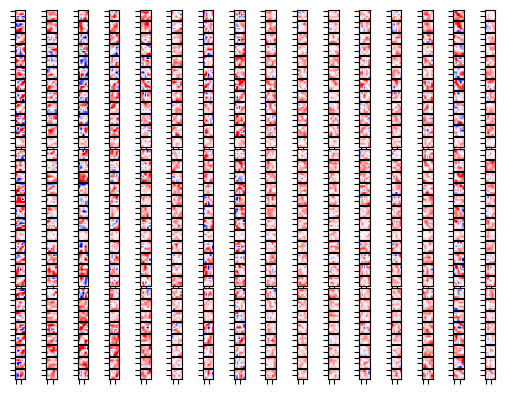

In [26]:
# Plot the channels
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample:

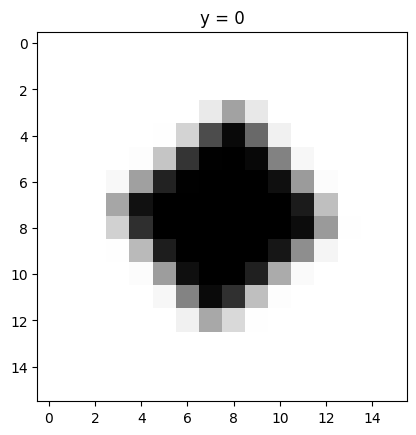

In [27]:
# Show the second image
show_data(train_dataset[1])

Determine the activations:

In [28]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 

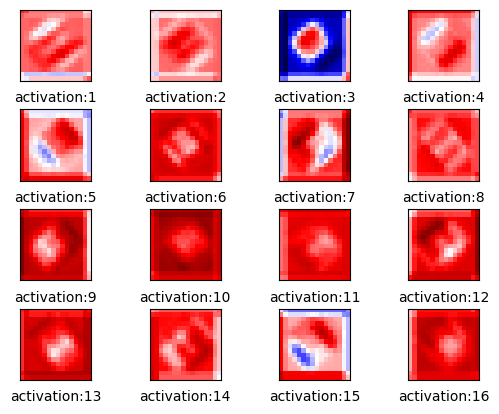

In [29]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function:

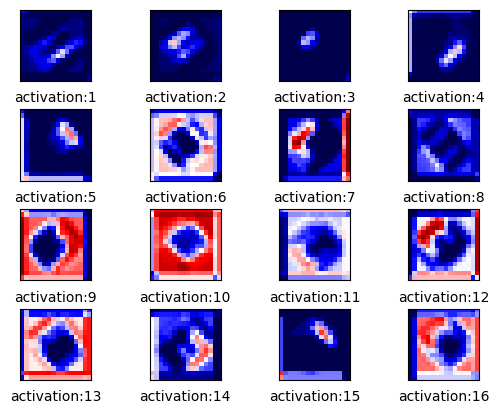

In [30]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.

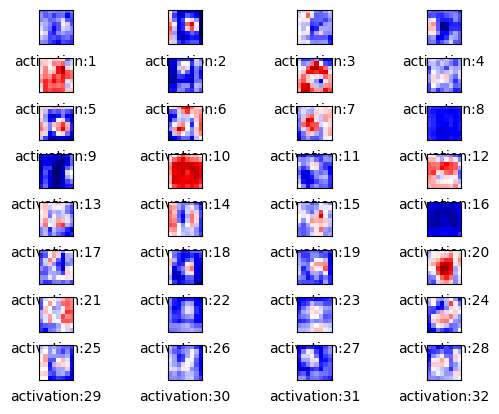

In [31]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu:

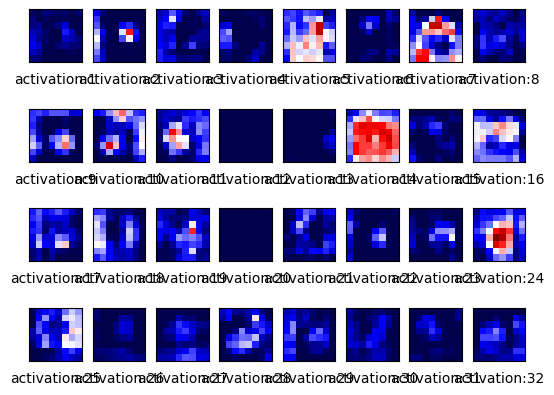

In [32]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

We can  see the result for the 3000th sample:

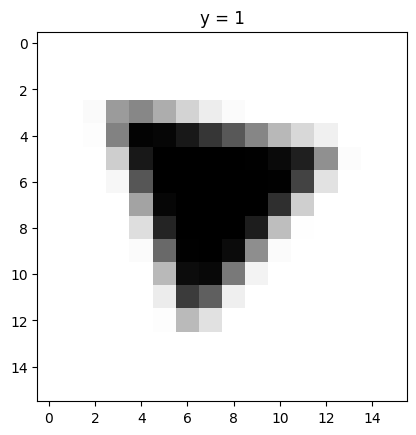

In [33]:
# Show the 3000th image
show_data(train_dataset[2999])

In [34]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[2999][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

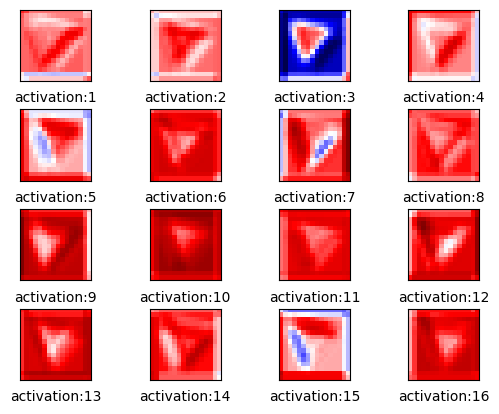

In [35]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

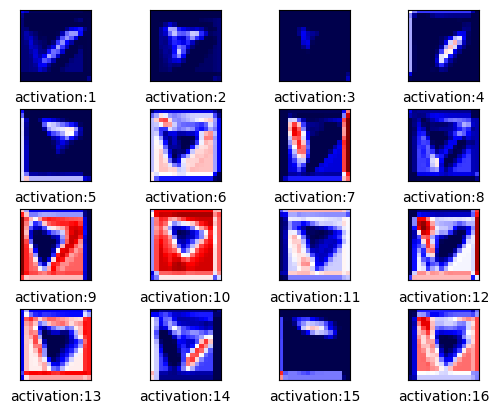

In [36]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

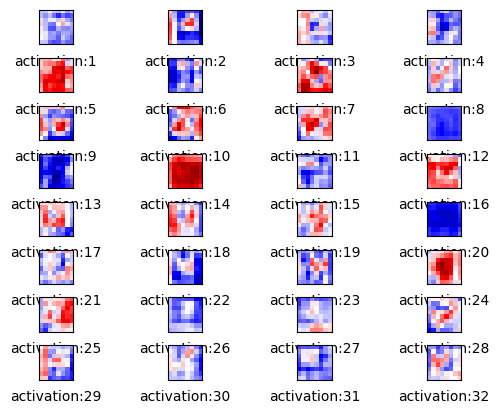

In [37]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

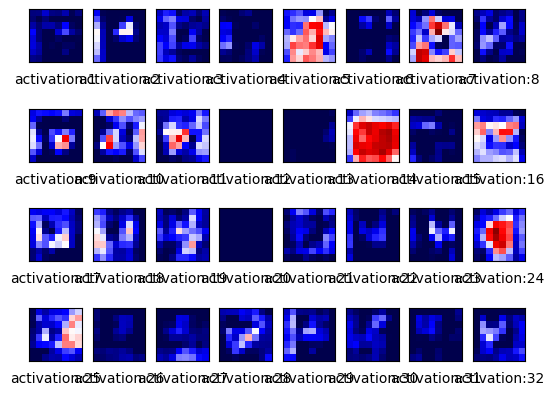

In [38]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Plot the first five mis-classified samples:

You will notice that the CNN misclassified squares as circles

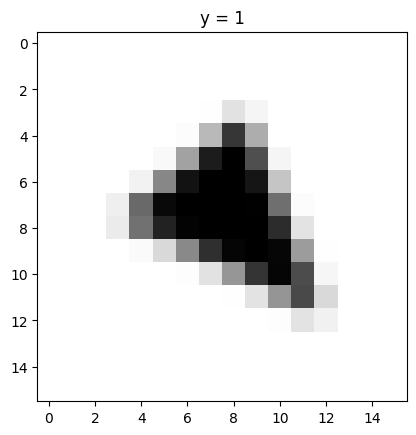

yhat:  tensor([2])


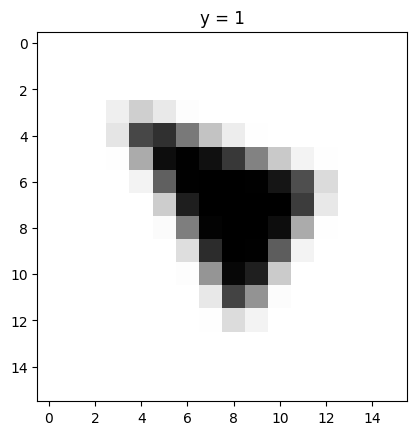

yhat:  tensor([2])


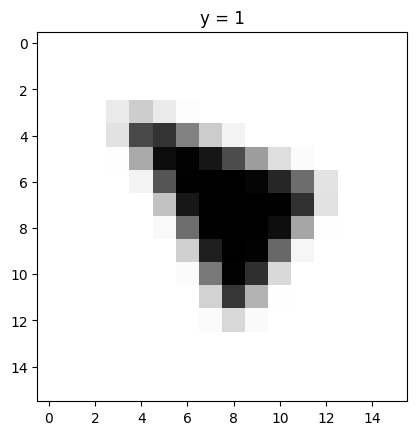

yhat:  tensor([2])


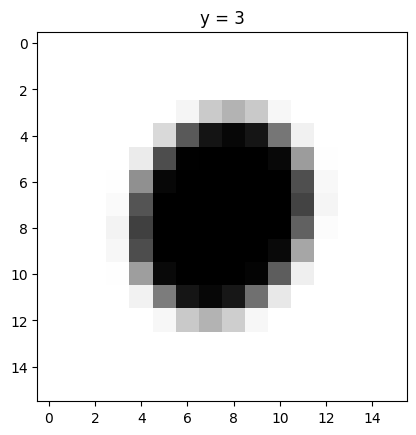

yhat:  tensor([0])


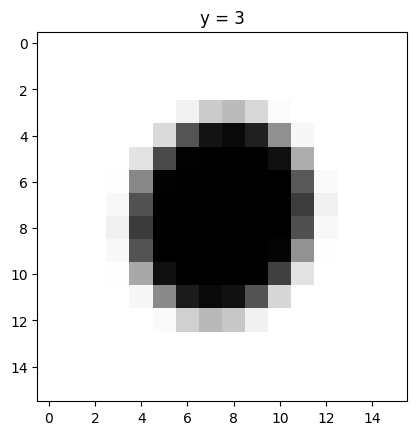

yhat:  tensor([0])


In [39]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/azim-hirjani-691a07179/">Azim Hirjani</a>

Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.